In [1]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
import scipy
import skimage
from tqdm import tqdm
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical

In [2]:
TRAIN_DIR = "../input/chest_xray/chest_xray/train/"
TEST_DIR =  "../input/chest_xray/chest_xray/test/"
VAL_DIR = "../input/chest_xray/chest_xray/val/"

In [3]:
def resize(path):
    img = cv2.imread(path)
    if img is not None:
        img = skimage.transform.resize(img, (200, 200, 3))
        img = np.asarray(img)
        return img

In [4]:
def preprocess(Dir, csv_name):
    labelArray = []
    fileNameArray=[]
    imagesArray=[]
    for nextdir in (os.listdir(Dir)):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                for image_filename in tqdm(os.listdir(Dir + nextdir)):
                    labelArray.append(0)
                    fileNameArray.append(image_filename)
                    imagesArray.append(resize(Dir + nextdir + '/' + image_filename))
            elif nextdir in ['PNEUMONIA']:
                for image_filename in tqdm(os.listdir(Dir +nextdir)):
                    labelArray.append(1)
                    fileNameArray.append(image_filename)
                    imagesArray.append(resize(Dir + nextdir + '/' + image_filename))
            else:
                for image_filename in tqdm(os.listdir(Dir+nextdir)):
                    labelArray.append(2)
                    fileNameArray.append(image_filename)
                    imagesArray.append(resize(Dir + nextdir + '/' + image_filename))
    data = list(zip(fileNameArray, labelArray))            
    df = pd.DataFrame(data)
    df.to_csv(csv_name, index_label=False, index=False, header=False)
    
    return np.array(imagesArray),np.array(labelArray)

In [5]:
X_train, Y_train = preprocess(TRAIN_DIR, 'train.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 3875/3875 [06:11<00:00, 10.43it/s]


In [6]:
X_test, Y_test = preprocess(TEST_DIR, 'test.csv')

100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:30<00:00, 12.61it/s]


In [7]:
X_val, Y_val = preprocess(VAL_DIR, 'val.csv')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 12.06it/s]


In [8]:
y_train = to_categorical(Y_train, 2)
y_test = to_categorical(Y_test, 2)

In [16]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K
print(K.image_data_format())
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

channels_last


In [17]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [18]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [19]:
def ResNet50(input_shape=(150, 150, 3), classes=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [62]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

model2 = Sequential()
model2.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(200,200,3)))
model2.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(200,200,3)))
model2.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model2.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model2.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model2.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())

model2.add(Dense(64, activation=swish_activation))
model2.add(Dropout(0.4))
model2.add(Dense(2 , activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.00005),
                  metrics=['accuracy'])

print(model2.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 200, 200, 16)      2320      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 50, 50, 64)       

In [63]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)
#lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', mode='auto', patience=1, verbose=1)

#factor 0.1
#min_delta 0.0001

filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

filepath2="weights2.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [23]:
#history = model.fit(X_train, y_train, validation_data = (X_test , y_test), callbacks=[lr_reduce,checkpoint],
#          epochs=12)
model = ResNet50(input_shape = (200, 200, 3), classes = 2)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,validation_data = (X_test , y_test), epochs = 15 ,callbacks=[checkpoint])

Train on 5216 samples, validate on 624 samples
Epoch 1/15
5184/5216 [============================>.] - ETA: 0s - loss: 0.9615 - accuracy: 0.8719
Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to weights.hdf5
5216/5216 [==============================] - 59s 11ms/sample - loss: 0.9569 - accuracy: 0.8721 - val_loss: 2.2204 - val_accuracy: 0.6250
Epoch 2/15
5184/5216 [============================>.] - ETA: 0s - loss: 0.1993 - accuracy: 0.9342
Epoch 00002: val_accuracy did not improve from 0.62500
5216/5216 [==============================] - 48s 9ms/sample - loss: 0.1992 - accuracy: 0.9342 - val_loss: 3.2679 - val_accuracy: 0.6250
Epoch 3/15
5184/5216 [============================>.] - ETA: 0s - loss: 0.3143 - accuracy: 0.9223
Epoch 00003: val_accuracy improved from 0.62500 to 0.62660, saving model to weights.hdf5
5216/5216 [==============================] - 51s 10ms/sample - loss: 0.3138 - accuracy: 0.9222 - val_loss: 4.3527 - val_accuracy: 0.6266
Epoch 4/15
5184/521

In [64]:

#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(X_train, y_train,validation_data = (X_test , y_test), epochs = 15 ,callbacks=[checkpoint2])

Train on 5216 samples, validate on 624 samples
Epoch 1/15
5184/5216 [============================>.] - ETA: 0s - loss: 0.5668 - accuracy: 0.7432
Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to weights2.hdf5
5216/5216 [==============================] - 12s 2ms/sample - loss: 0.5664 - accuracy: 0.7431 - val_loss: 0.6279 - val_accuracy: 0.6250
Epoch 2/15
5184/5216 [============================>.] - ETA: 0s - loss: 0.4203 - accuracy: 0.7933
Epoch 00002: val_accuracy improved from 0.62500 to 0.76442, saving model to weights2.hdf5
5216/5216 [==============================] - 11s 2ms/sample - loss: 0.4193 - accuracy: 0.7940 - val_loss: 0.5032 - val_accuracy: 0.7644
Epoch 3/15
5184/5216 [============================>.] - ETA: 0s - loss: 0.3260 - accuracy: 0.8546
Epoch 00003: val_accuracy improved from 0.76442 to 0.81651, saving model to weights2.hdf5
5216/5216 [==============================] - 11s 2ms/sample - loss: 0.3267 - accuracy: 0.8539 - val_loss: 0.4346 - val_a

In [ ]:
model.load_weights('weights.hdf5')
model2.load_weights('weights2.hdf5')

predictions = model.predict(X_val)
predictions2 = model2.predict(X_val)

In [55]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{:2.0f}%".format(100*np.max(predictions_array)),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(2))
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

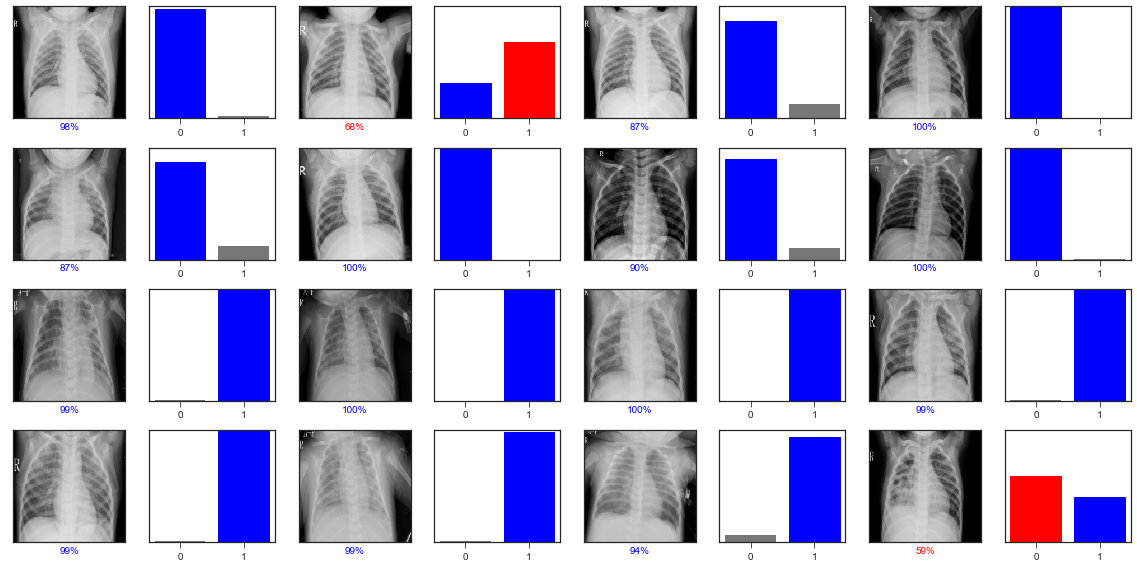

In [56]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], Y_val, X_val)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], Y_val)
plt.tight_layout()
plt.show()

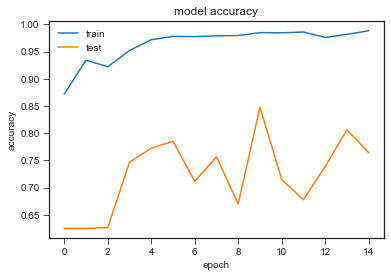

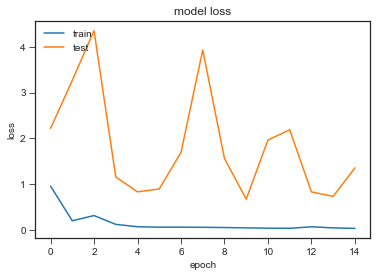

In [57]:
plt.style.use('seaborn-ticks')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

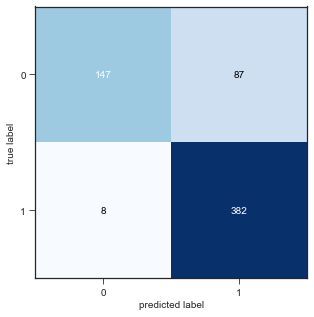

In [66]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [58]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

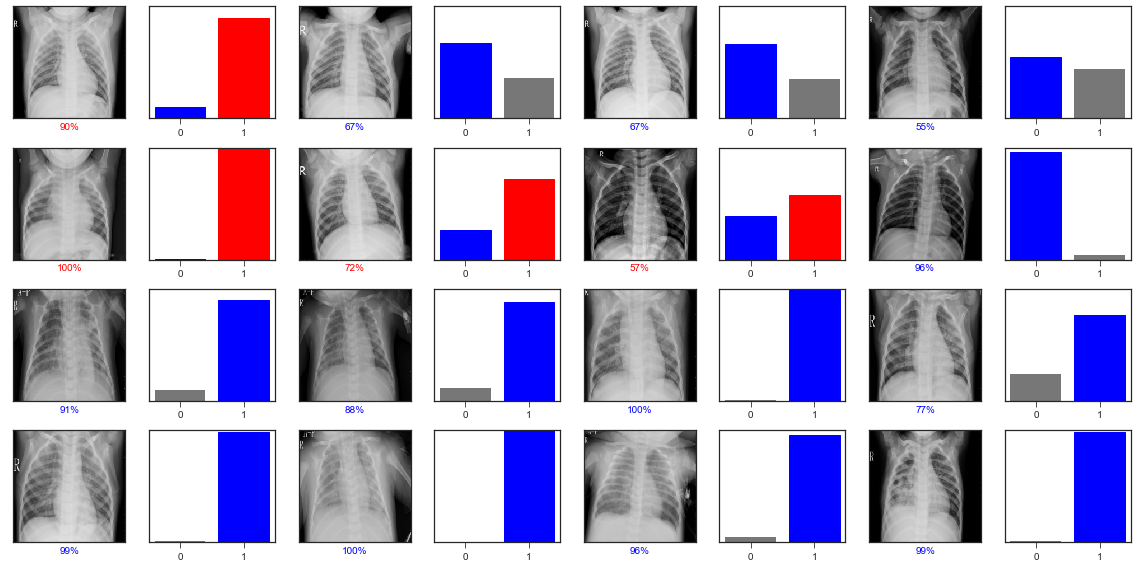

In [59]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions2[i], Y_val, X_val)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions2[i], Y_val)
plt.tight_layout()
plt.show()

In [60]:
print(predictions2)

[[1.04495496e-01 8.97953153e-01]
 [6.71590686e-01 3.59387994e-01]
 [6.65167153e-01 3.48602086e-01]
 [5.51409364e-01 4.45395142e-01]
 [2.69359350e-03 9.98032928e-01]
 [2.65639752e-01 7.16304958e-01]
 [3.86859775e-01 5.73635876e-01]
 [9.63045120e-01 4.56619859e-02]
 [9.43132043e-02 9.05279517e-01]
 [1.15506738e-01 8.83887291e-01]
 [5.93221188e-03 9.95373309e-01]
 [2.38962770e-01 7.71734118e-01]
 [1.44519806e-02 9.88587081e-01]
 [9.87738371e-04 9.99447465e-01]
 [4.45232987e-02 9.60406661e-01]
 [1.50254965e-02 9.86255348e-01]]


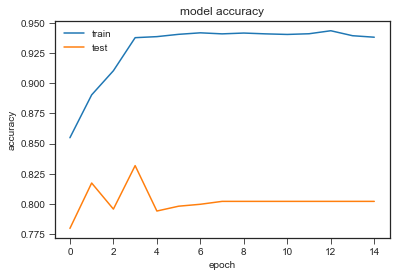

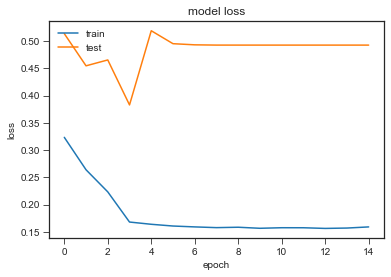

In [61]:
plt.style.use('seaborn-ticks')
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

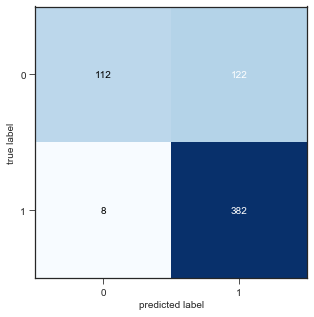

In [67]:
from sklearn.metrics import confusion_matrix
pred = model2.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()